In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [1]:
import numpy as np
import sys
from pathlib import Path

# Make `import src.*` work when running from nested directory
REPO_ROOT = Path.cwd().resolve()
if not (REPO_ROOT / "src").exists() and (REPO_ROOT.parent / "src").exists():
    REPO_ROOT = REPO_ROOT.parent.resolve()

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
    
from src import (
    ExperimentConfig,
    load_config,
    list_datasets,
    list_models,
    run_pipeline,
)

# Load a base YAML config from ./config/ (convenience wrapper)
cfg = load_config("base_no_pca.yaml")
#cfg.data.data_type=""

print("datasets:", list_datasets())
print("models:", list_models())

datasets: ['breast_cancer_tabular', 'cifar10', 'cifar100', 'fashion_mnist', 'geometrical-shapes', 'mnist', 'synthetic_shapes_2class', 'synthetic_shapes_3class', 'two_moons']
models: ['minicnn, minicnn_mnist', 'two_moons_mlp']


/Users/miki/Desktop/TDA_Images/topology-and-robustness-in-DNNs/venv/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


AUROC: 0.4485838779956427
AUPRC: 0.30652344161723066
FPR@95TPR: 0.97


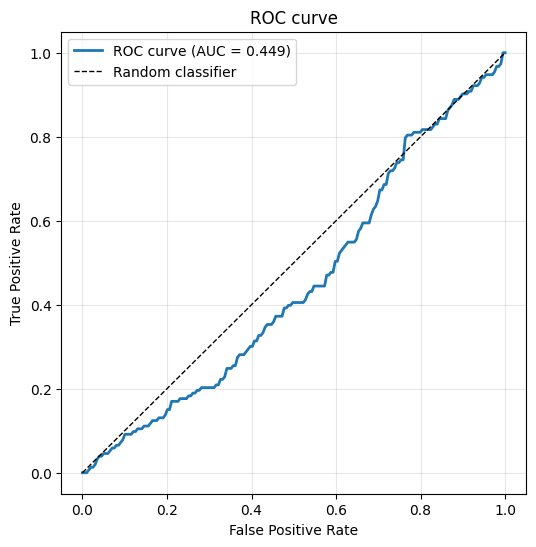

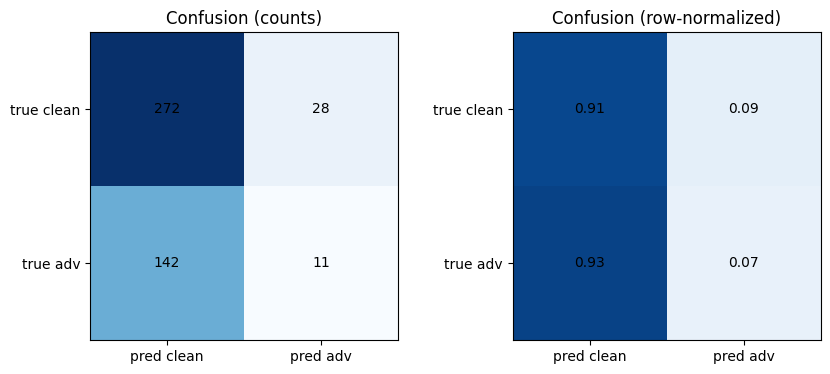

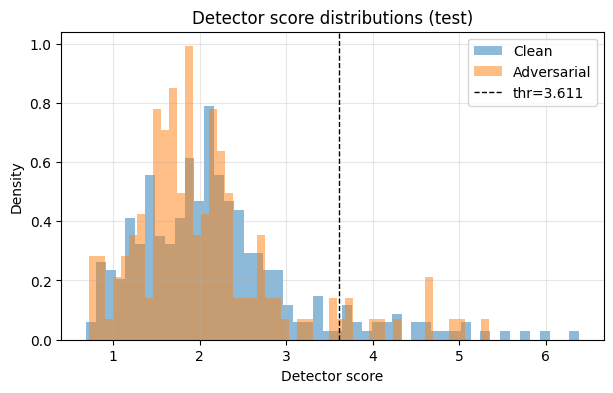

In [2]:
cfg = load_config("mnist_fast")
cfg.data.root = "../data"
cfg.data.download = False

# NEW: dramatically reduce MNIST load time
cfg.data.max_full_train = 5000
cfg.data.max_full_test = 1000
cfg.graph.space = "feature"

result = run_pipeline(
    dataset_name="mnist",
    model_name="minicnn_mnist",
    cfg=cfg,
    model_kwargs={"feat_dim": 64},
    max_points_for_scoring=300,    # keep small
    filter_clean_to_correct=True,
    eval_only_successful_attacks=True,
)

print("AUROC:", result.eval.metrics["roc_auc"])
print("AUPRC:", result.eval.metrics["pr_auc"])
print("FPR@95TPR:", result.eval.metrics["fpr_at_tpr95"])


In [3]:
adv_mask = result.attack_test.meta["adv_mask"]
clean_mask = result.attack_test.meta["clean_mask"]

print("test total:", len(adv_mask))
print("clean correct fraction:", clean_mask.mean())
print("attack success fraction:", adv_mask.mean())


test total: 1000
clean correct fraction: 0.599
attack success fraction: 0.153


In [4]:
import numpy as np
import torch
from copy import deepcopy

from src.models import extract_features_batch, get_model_logits
from src.graph_scoring import compute_graph_scores
from src.detectors import train_graph_detector, predict_graph_detector
from src.evaluation import evaluate_detector

trained = result.model
bundle = result.bundle

device = str(result.cfg.device)

# choose reference space for the *training* graph
def build_train_reference(space: str):
    if space == "feature":
        Z_train = extract_features_batch(trained, bundle.X_train, layer="penultimate", device=device, batch_size=256)
    else:
        Z_train = np.asarray(bundle.X_train)

    logits = get_model_logits(trained, bundle.X_train, device=device)
    probs = torch.softmax(torch.as_tensor(logits, dtype=torch.float32), dim=1).cpu().numpy()
    f_train = probs.max(axis=1)  # scalar confidence used by compute_graph_scores
    return Z_train, f_train

Z_train_feat, f_train = build_train_reference("feature")
Z_train_inp,  _      = build_train_reference("input")


In [6]:
def eval_variant(*, space="feature", use_topology=True, topo_maxdim=1):
    cfg2 = deepcopy(result.cfg)
    cfg2.graph.space = space
    cfg2.graph.use_topology = use_topology
    cfg2.graph.topo_maxdim = topo_maxdim

    # Use the exact same subsets the pipeline used last time (already masked + subsampled)
    # We'll reconstruct them using the stored masks and then cap to N for speed.
    N = 300

    # Clean/adv masks stored by run_pipeline
    m_val_clean = np.asarray(result.attack_val.meta["clean_mask"], dtype=bool)
    m_val_adv   = np.asarray(result.attack_val.meta["adv_mask"], dtype=bool)
    m_test_clean= np.asarray(result.attack_test.meta["clean_mask"], dtype=bool)
    m_test_adv  = np.asarray(result.attack_test.meta["adv_mask"], dtype=bool)

    rng = np.random.default_rng(int(cfg2.seed))

    def pick(X, y, mask, n):
        idx = np.where(mask)[0]
        if len(idx) == 0:
            return X[:0], y[:0]
        if len(idx) > n:
            idx = rng.choice(idx, size=n, replace=False)
        return X[idx], y[idx]

    Xv_clean, yv = pick(bundle.X_val, bundle.y_val, m_val_clean, N)
    Xv_adv, _    = pick(result.attack_val.X_adv, bundle.y_val, m_val_adv, N)

    Xt_clean, yt = pick(bundle.X_test, bundle.y_test, m_test_clean, N)
    Xt_adv, _    = pick(result.attack_test.X_adv, bundle.y_test, m_test_adv, N)

    Z_train = Z_train_feat if space == "feature" else Z_train_inp

    # compute scores
    scores_val_clean = compute_graph_scores(X_points=Xv_clean, model=trained, Z_train=Z_train, f_train=f_train,
                                            graph_params=cfg2.graph, device=device)
    scores_val_adv   = compute_graph_scores(X_points=Xv_adv,   model=trained, Z_train=Z_train, f_train=f_train,
                                            graph_params=cfg2.graph, device=device)
    scores_test_clean= compute_graph_scores(X_points=Xt_clean, model=trained, Z_train=Z_train, f_train=f_train,
                                            graph_params=cfg2.graph, device=device)
    scores_test_adv  = compute_graph_scores(X_points=Xt_adv,   model=trained, Z_train=Z_train, f_train=f_train,
                                            graph_params=cfg2.graph, device=device)

    # fit detector on val
    def concat(a, b):
        keys = sorted(set(a.keys()) | set(b.keys()))
        return {k: np.concatenate([a.get(k), b.get(k)], axis=0) for k in keys}

    scores_val_all = concat(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    y_val_lab = np.concatenate([np.zeros(len(scores_val_clean[any_key])), np.ones(len(scores_val_adv[any_key]))]).astype(int)

    det = train_graph_detector(scores_val_all, y_val_lab, cfg2.detector)

    # eval on test
    scores_test_all = concat(scores_test_clean, scores_test_adv)
    any_key_t = next(iter(scores_test_all.keys()))
    y_test_lab = np.concatenate([np.zeros(len(scores_test_clean[any_key_t])), np.ones(len(scores_test_adv[any_key_t]))]).astype(int)

    raw = np.asarray(det.score(scores_test_all), dtype=float)
    thr = float(det.threshold)
    metrics = evaluate_detector(y_test_lab, raw, threshold=thr)
    return metrics


In [7]:
m3 = eval_variant(space="feature", use_topology=True, topo_maxdim=0)
print("Feature space, topo maxdim=0 AUROC:", m3["roc_auc"])


KeyboardInterrupt: 

In [8]:
m1 = eval_variant(space="feature", use_topology=False)
m2 = eval_variant(space="input",   use_topology=False)

print("Feature space, no topology AUROC:", m1["roc_auc"])
print("Input space,   no topology AUROC:", m2["roc_auc"])


KeyboardInterrupt: 